In [1]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from torchvision.models import resnet34, ResNet34_Weights
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, Grayscale

from zennit.attribution import Gradient, SmoothGrad
from zennit.torchvision import ResNetCanonizer
from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat
from zennit.image import imgify, imsave

from PIL import Image

from tempo.models import NewTempoLinear
from tempo.data.datasets import finetune_dataset2

In [2]:
# load models
weights_tp = torch.load('../model_zoo/asl_big_e10_p30_run5.pth')
model_tp = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_tp.load_state_dict(weights_tp)
model_tp.requires_grad = True
_ = model_tp.eval()

weights_bl = torch.load('../model_zoo/baseline.pth')
model_bl = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_bl.load_state_dict(weights_bl)
model_bl.requires_grad = True
_ = model_bl.eval()

In [3]:
def get_relevance(model, data, num_classes):

    with torch.no_grad():
        pred = torch.argmax(model(data).flatten()).item()

    canonizer = ResNetCanonizer()

    # create a composite, specifying the canonizers
    composite = EpsilonPlusFlat(canonizers=[canonizer])

    # choose a target class for the attribution (label 437 is lighthouse)
    target = torch.eye(num_classes)[[pred]]

    # create the attributor, specifying model and composite
    with Gradient(model=model, composite=composite) as attributor:
        # compute the model output and attribution
        output, attribution = attributor(data, target)

    relevance = attribution.sum(1)

    return pred, relevance

In [4]:
# Load test-set
test_loader = finetune_dataset2(train=False, batch_size=1)

# for i, data in enumerate(test_loader, 0):
#     inputs, labels = data

input, label = next(iter(test_loader))    

In [5]:
input.shape

torch.Size([1, 3, 128, 128])

In [6]:
get_relevance(model_tp, input, 24)

(17,
 tensor([[[5.2858e-05, 5.5393e-05, 5.5393e-05,  ..., 7.8441e-06,
           4.0329e-06, 4.0329e-06],
          [5.6110e-05, 5.9086e-05, 5.9086e-05,  ..., 8.8528e-06,
           4.7765e-06, 4.7765e-06],
          [5.6110e-05, 5.9086e-05, 5.9086e-05,  ..., 8.8528e-06,
           4.7765e-06, 4.7765e-06],
          ...,
          [1.2136e-05, 1.4034e-05, 1.4034e-05,  ..., 3.6752e-06,
           1.6882e-06, 1.6882e-06],
          [4.2286e-06, 5.3129e-06, 5.3129e-06,  ..., 1.7373e-06,
           8.7877e-07, 8.7877e-07],
          [4.2286e-06, 5.3129e-06, 5.3129e-06,  ..., 1.7373e-06,
           8.7877e-07, 8.7877e-07]]]))

In [7]:
normalize = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # imagenet normalization, also applied during tempo training

In [8]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

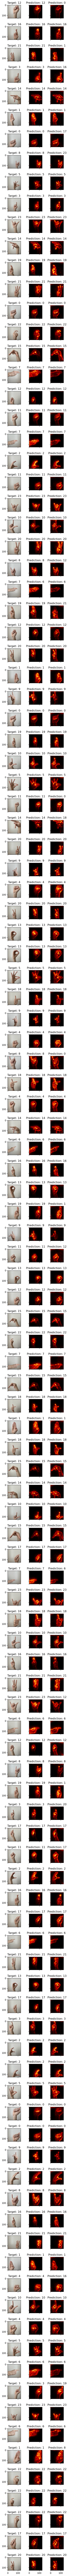

In [9]:
fig = plt.figure(figsize=(200., 200.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(test_loader.dataset.__len__(), 3),
                 axes_pad=0.5,
                 )

grid = chunker(grid, 3)
for ax, (im, lbl) in zip(grid, test_loader):
    img_n = normalize(im)
    pred, relevance = get_relevance(model_tp, img_n, 24)
    pred_bl, relevance_bl = get_relevance(model_bl, img_n, 24)
    img_hm = imgify(relevance, symmetric=True, cmap='coldnhot')
    img_hm_bl = imgify(relevance_bl, symmetric=True, cmap='coldnhot')

    ax[0].set_title(f'Target: {lbl.item()}')
    ax[1].set_title(f'Prediction: {pred}')
    ax[2].set_title(f'Prediction: {pred_bl}')

    im = im[0]
    ax[0].imshow(im.permute(1,2,0))
    ax[1].imshow(img_hm)
    ax[2].imshow(img_hm_bl)

plt.show()